# Week 7: Confidence Intervals (of means and proportions) Based on the Assumption of Normality or the Central Limit Theorem

#### Lecture and Tutorial Learning Goals:
From this section, students are expected to be able to:

1. Describe the Law of Large Numbers.
2. Describe a normal distribution.
3. Explain the Central Limit Theorem and its role in constructing confidence intervals.
4. Write a computer script to calculate confidence intervals based on the assumption of normality / the Central Limit Theorem.
5. Discuss the potential limitations of these methods.
6. Decide whether to use asymptotic theory or bootstrapping to compute estimator uncertainty.

In [1]:
# Run this cell before continuing.
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
source("tests_tutorial_07.R")

── Attaching packages ────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches




## 1. Estimating the Mean using CLT

In this section, we will use the Central Limit Theorem to obtain interval estimates (i.e., confidence intervals) for the population mean instead of the simulation approach we used in Week 4. 

The US Food & Drug Administration (FDA) monitored the mercury level in many different commercial fishes and shellfish between 1990 and 2010. The mercury levels were measured in parts per million (ppm). This study is very relevant because a high mercury level is toxic to people and can cause brain problems and affect the fetus. Pretty serious!! 

Let us start by loading and taking a peek at the dataset.

In [2]:
salmon <- read_csv("salmon.csv")
head(salmon)

Rows: 94 Columns: 2

── Column specification ───────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): fish_species
dbl (1): mercury_concentration


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



fish_species,mercury_concentration
<chr>,<dbl>
salmon,0.11
salmon,0.00
salmon,0.00
salmon,0.06
salmon,0.12
salmon,0.19


**Question 1.1**
<br> {points: 1}

Since we will be relying on the CLT, it is good to check if there is no severe violation of the CLT's assumptions. A good first step is to check the sample distribution to understand what sort of distribution we are dealing with. Remember that the sample distribution is an estimate of the population distribution. This step is important because "weird" distributions, such as asymmetric and/or multimodal distributions **might** require bigger sample sizes for the CLT to kick-in.

Your job in this exercise is to plot the histogram of `mercury_concentration` of salmon. 

_Assign your plot to an object called `salmon_sample_dist`._

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



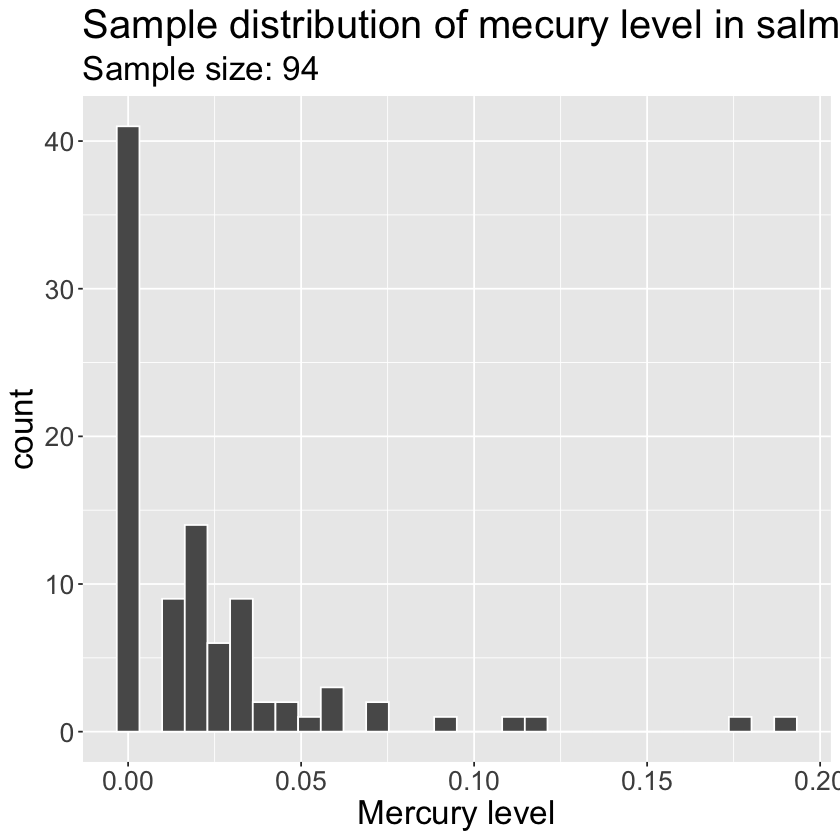

In [3]:
### BEGIN SOLUTION
salmon_sample_dist <- 
    salmon %>% 
    ggplot() + 
    geom_histogram(aes(mercury_concentration), color = 'white') + 
    theme(text = element_text(size = 20)) + 
    xlab("Mercury level") +
    ggtitle("Sample distribution of mecury level in salmon", subtitle = "Sample size: 94")
### END SOLUTION

salmon_sample_dist

In [4]:
test_1.1()

Test passed 🥇
Test passed 🥳
Test passed 🥇
Test passed 🥳
Test passed 🥳
Test passed 🎊
Test passed 🥳
Test passed 🥳
[1] "Success!"


**Question 1.2**
<br>{points: 1}

Based on the previous question's sample distribution plot, select all that apply:

A. The distribution is symmetric;

B. The distribution is left-skewed;

C. The distribution is right-skewed;

D. The distribution is multimodal;

E. The distribution is unimodal;

F. The distribution is quite similar to the Normal distribution;

_Assign your answer to an object called `answer1.2`. Your answer should be a sequence of characters surrounded by quotes, e.g., "ACF"._

In [5]:
# answer1.2 <- ...

### BEGIN SOLUTION
answer1.2 <- "CE"
### END SOLUTION

In [6]:
# Here we check to see if you have given your answer the correct object name
# and if your answer is plausible. However, all other tests have been hidden
# so you can practice deciding when you have the correct answer.
test_that('Did not assign answer to an object called "answer1.2"', {
  expect_true(exists("answer1.2"))
})

### BEGIN HIDDEN TESTS
answer_hash  <- digest(tolower(paste(sort(unlist(strsplit(answer1.2, ""))), collapse = "")))
test_that("Solution is incorrect", {
  expect_equal(answer_hash, "af3b9dd3ec5caf00ed91c392d69f070d")
})
print("Success!")
### END HIDDEN TESTS

Test passed 🎊
Test passed 😸
[1] "Success!"


**Question 1.3**
<br> {points: 4}

The previous question showed that the population is quite asymmetric, with most salmons presenting low mercury levels but some salmons presenting much higher levels. Asymmetry, especially with outliers, might require a larger **n** for the CLT to kick in. On the other hand, our sample size is already somewhat large, with 94 fish in the sample. 

Remember that, if the conditions are satisfied, the CLT states that the $\bar{X}\sim N\left(\mu, \sigma/\sqrt{n}\right)$ . 

If you have a strong suspicion that your sample size is not large enough, you might want to consider using the bootstrap approach. Let's take a look at the approximation of the sampling distribution provided by both approaches: bootstrap and CLT. Let's use the sample mean and standard deviation as placeholders for $\mu$ and $\sigma$, respectively, in the case of CLT.

Your job:

1. Calculate the sample mean and store it in an object called `salmon_x_bar`. Note: `salmon_x_bar` must be a number, not a `tibble`.
2. Calculate the estimate of the standard error of $\bar{X}$ and store it in an object called `salmon_std_error`. Note: `salmon_std_error` must be a number, not a `tibble`.
3. Obtain the bootstrap sampling distribution using 2000 bootstrap samples and store them in a data frame called `salmon_btsp_samp_dist`. Note: the data frame `salmon_btsp_samp_dist` must have two columns only: (1) `replicate`; and (2) `stat`.
4. Create the histogram to visualize the bootstrap sampling distribution vs the Normal density given by the CLT. Assign your plot to an object called `salmon_btsp_vs_clt_samp_dist_plot`.

Setting `type = "bootstrap"` in `generate()`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



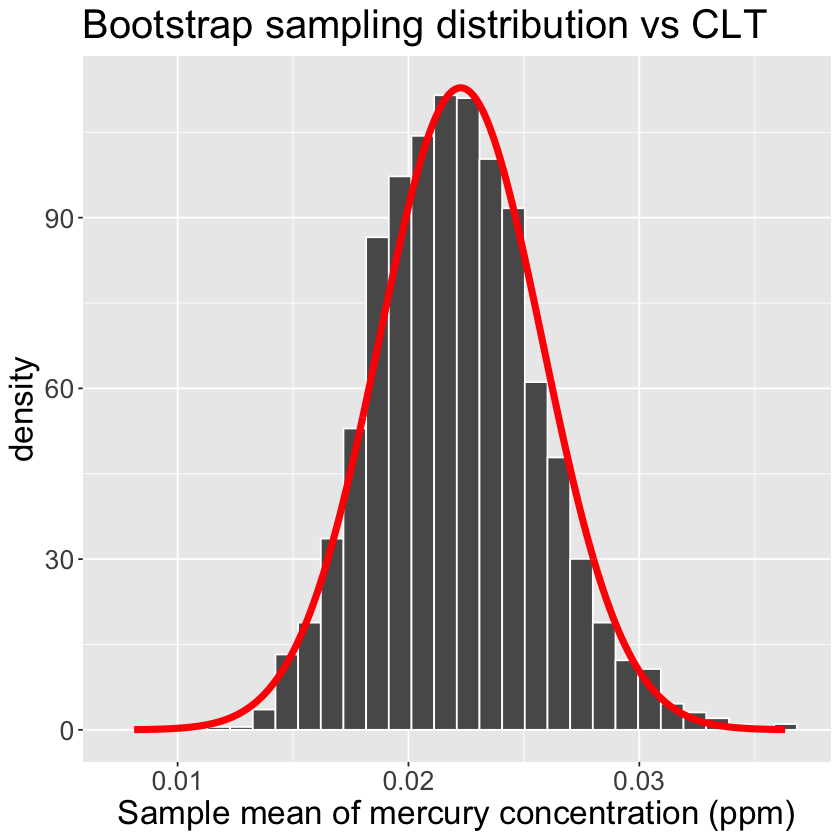

In [7]:
set.seed(20210201) # Do not change this

# # Obtain the sample mean
# salmon_x_bar <- mean(salmon$...)

# # Obtain the sample std. error 
# salmon_std_error <- ...

# # Done for you: the normal curve
# clt_samp_dist <- 
#     tibble(x = seq(salmon_x_bar - 4 * salmon_std_error, 
#                    salmon_x_bar + 4 * salmon_std_error, 0.0001),
#            density = dnorm(x, salmon_x_bar, salmon_std_error))

# # Obtain the boostrap sampling distribution
# salmon_btsp_samp_dist <-
#     salmon %>% 
#     ...

# # Let's plot the bootstrap vs the CLT estimates
# salmon_btsp_vs_clt_samp_dist_plot <- 
#     salmon_btsp_samp_dist %>% 
#     ggplot() + 
#     geom_histogram(aes(..., ..density..), color = 'white') + 
#     geom_line(data = clt_samp_dist, aes(x, density), lwd = 2, color = "red") + 
#     ... + 
#     ... + 
#     theme(text = element_text(size = 20))

### BEGIN SOLUTION

salmon_std_error <- sd(salmon$mercury_concentration) / sqrt(nrow(salmon))
salmon_x_bar <- mean(salmon$mercury_concentration)
clt_samp_dist <- tibble(x = seq(salmon_x_bar - 4 * salmon_std_error, salmon_x_bar + 4 * salmon_std_error, 0.0001),
                        density = dnorm(x, salmon_x_bar, salmon_std_error))

salmon_btsp_samp_dist <-
    salmon %>% 
    specify(response = mercury_concentration) %>% 
    generate(reps = 2000) %>% 
    calculate(stat = "mean")

salmon_btsp_vs_clt_samp_dist_plot <- 
    salmon_btsp_samp_dist %>% 
    ggplot() + 
    geom_histogram(aes(stat, ..density..), color = 'white') + 
    xlab("Sample mean of mercury concentration (ppm)") + 
    geom_line(data = clt_samp_dist, aes(x, density), lwd = 2, color = "red") + 
    ggtitle("Bootstrap sampling distribution vs CLT") + 
    theme(text = element_text(size = 20))

### END SOLUTION

salmon_btsp_vs_clt_samp_dist_plot

In [8]:
test_1.3()

Test passed 😀
Test passed 🎊
Test passed 🎉
[1] "Success!"
Test passed 😀
Test passed 🎉
Test passed 🎊
[1] "Success!"
Test passed 🥇
Test passed 🥳
Test passed 🥳
Test passed 🎉
Test passed 😸
[1] "Success!"
Test passed 🎊
Test passed 🥇
Test passed 🥇
Test passed 🥳
Test passed 🌈
Test passed 🎊
Test passed 🎉
Test passed 😸
[1] "Success!"


As we can see from the plot above, the sampling distribution estimates given by the CLT and boostrap approaches are fairly close. Therefore, from this similarity, we could already expect that both confidence intervals will be similar. 

**Question 1.4** 
<br> {points: 1}


Obtain the 92.8% confidence interval for the mean mercury levels in fish and shellfish applying the CLT.

_Assign your data frame to an object called `salmon_clt_ci`. The data frame should have two columns: (1) `lower_ci`; and `upper_ci`_

In [9]:
# salmon_clt_ci <- 
#     tibble(lower_ci = ... + qnorm(...) * ..., 
#            upper_ci = ... )

### BEGIN SOLUTION
salmon_clt_ci <- 
    tibble(lower_ci = salmon_x_bar + qnorm(0.036) * salmon_std_error, 
           upper_ci = salmon_x_bar - qnorm(0.036) * salmon_std_error)
### END SOLUTION

head(salmon_clt_ci)

lower_ci,upper_ci
<dbl>,<dbl>
0.01590012,0.02862329


In [10]:
# Here we check to see if you have given your answer the correct object name
# and if your answer is plausible. However, all other tests have been hidden
# so you can practice deciding when you have the correct answer.
test_that('Did not assign answer to an object called "salmon_clt_ci"', {
  expect_true(exists("salmon_clt_ci"))
})
test_that("Solution should be a data frame", {
  expect_true("data.frame" %in% class(salmon_clt_ci))
})
test_that("Data frame does not contain the correct number of rows", {
  expect_equal(digest(as.integer(nrow(salmon_clt_ci))), "4b5630ee914e848e8d07221556b0a2fb")
})


### BEGIN HIDDEN TESTS
expected_colnames <- c("lower_ci", "upper_ci")
given_colnames <- colnames(salmon_clt_ci)
test_that("Data frame does not have the correct columns", {
  expect_equal(length(setdiff(
    union(expected_colnames, given_colnames),
    intersect(expected_colnames, given_colnames)
  )), 0)
})

test_that("Data frame does not contain the correct data", {
  expect_equal(digest(as.integer(salmon_clt_ci$lower_ci+salmon_clt_ci$upper_ci * 10e6)), "cf2ec3721d3e32d27f29f27ce598a4d9")
})

print("Success!")
### END HIDDEN TESTS

Test passed 🎉
Test passed 🥇
Test passed 🥳
Test passed 🎉
Test passed 🌈
[1] "Success!"


**Question 1.5** 
<br> {points: 1}


Obtain the 92.8% confidence interval for the mean mercury levels in fish and shellfish using the bootstrap distribution you obtained previously: `salmon_btsp_samp_dist`.

_Assign your data frame to an object called `salmon_btsp_ci`. The data frame should have two columns: (1) `lower_ci`; and `upper_ci`_

In [11]:
# salmon_btsp_ci <- 
#     salmon_btsp_samp_dist %>% 
#     ...

### BEGIN SOLUTION
salmon_btsp_ci <- 
    salmon_btsp_samp_dist %>% 
    get_ci(level = 0.928)
### END SOLUTION

head(salmon_btsp_ci)

lower_ci,upper_ci
<dbl>,<dbl>
0.0162112,0.02882246


In [12]:
test_1.5()

Test passed 🎊
Test passed 🥇
Test passed 🥇
Test passed 🎊
Test passed 😀
[1] "Success!"


As we imagined, the CLT and bootstrap confidence intervals are quite close.

## 2. Estimating the Difference in Means using CLT

Is parking in Downtown Vancouver more expensive than in Kitsilano?
For this question, we will use the Vancouver parking meter data set. 
First, let's preview the dataset.

In [13]:
?parking_meters

Warning message in seq_len(head.end.idx):
“first element used of 'length.out' argument”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): argument must be coercible to non-negative integer

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_conte

In [14]:
head(parking_meters)

meter_head,r_mf_9a_6p,r_mf_6p_10,r_sa_9a_6p,r_sa_6p_10,r_su_9a_6p,r_su_6p_10,rate_misc,time_in_effect,t_mf_9a_6p,⋯,t_sa_6p_10,t_su_9a_6p,t_su_6p_10,time_misc,credit_card,pay_phone,longitude,latitude,geo_local_area,meter_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Twin,$2.00,$4.00,$2.00,$4.00,$2.00,$4.00,NA,METER IN EFFECT: 9:00 AM TO 10:00 PM,2 Hr,⋯,4 Hr,2 Hr,4 Hr,NA,No,66890,-123.1289,49.28690,West End,670805
Pay Station,$1.00,$1.00,$1.00,$1.00,$1.00,$1.00,$ .50,METER IN EFFECT: 9:00 AM TO 10:00 PM,10 Hrs,⋯,10 Hrs,10 Hrs,10 Hrs,No Time Limit,Yes,59916,-123.0982,49.27215,Strathcona,471405
Twin,$1.00,$1.00,$1.00,$1.00,$1.00,$1.00,NA,METER IN EFFECT: 9:00 AM TO 10:00 PM,2 Hr,⋯,4 Hr,2 Hr,4 Hr,NA,No,57042,-123.1013,49.25468,Riley Park,C80145
Single,$1.00,$1.00,$1.00,$1.00,$1.00,$1.00,NA,METER IN EFFECT: 9:00 AM TO 10:00 PM,2 Hr,⋯,4 Hr,2 Hr,4 Hr,NA,No,57159,-123.1862,49.26341,West Point Grey,D03704
Twin,$2.00,$1.00,$2.00,$1.00,$2.00,$1.00,NA,METER IN EFFECT: 9:00 AM TO 10:00 PM,2 Hr,⋯,4 Hr,2 Hr,4 Hr,NA,No,51104,-123.1278,49.26354,Fairview,301023
Twin,$2.00,$1.00,$2.00,$1.00,$2.00,$1.00,NA,METER IN EFFECT: 9:00 AM TO 10:00 PM,3 Hr,⋯,4 Hr,3 Hr,4 Hr,NA,No,60868,-123.1265,49.27431,Downtown,591318


Let's focus on 9 am to 10 pm Monday to Friday's rate. We will take a sample of 53 downtown meters and a sample of 40 Kitsilano meters. The sample is stored in `downtown_kitsilano_sample`.

In [15]:
# Run this cell before continuing

set.seed(4759)

parking_pop <- # Some data cleaning
    parking_meters %>% 
    filter((geo_local_area %in% c("Downtown", "Kitsilano")) & (!is.na(r_mf_9a_6p))) %>%
    select(geo_local_area, r_mf_9a_6p) %>% 
    mutate(r_mf_9a_6p = as.numeric(str_remove(r_mf_9a_6p, "\\$")))

downtown_kitsilano_sample <- # Taking the sample
    parking_pop %>% 
    group_by(geo_local_area) %>% 
    sample_n(size = case_when(geo_local_area == "Downtown" ~ 53,
                              geo_local_area == "Kitsilano" ~ 40), replace = FALSE) %>% 
    ungroup()

downtown_kitsilano_sample %>% # Let's take a peek
    group_by(geo_local_area) %>% 
    sample_n(size = 3)

geo_local_area,r_mf_9a_6p
<chr>,<dbl>
Downtown,5
Downtown,1
Downtown,2
Kitsilano,5
Kitsilano,1
Kitsilano,4


**Question 2.1**
<br> {points: 1}

As usual, let's start by checking the sample distribution of each neighbourhood. Use `binwidth = 1`.

_Assign your plot to an object called `parking_samp_dist_plot`._

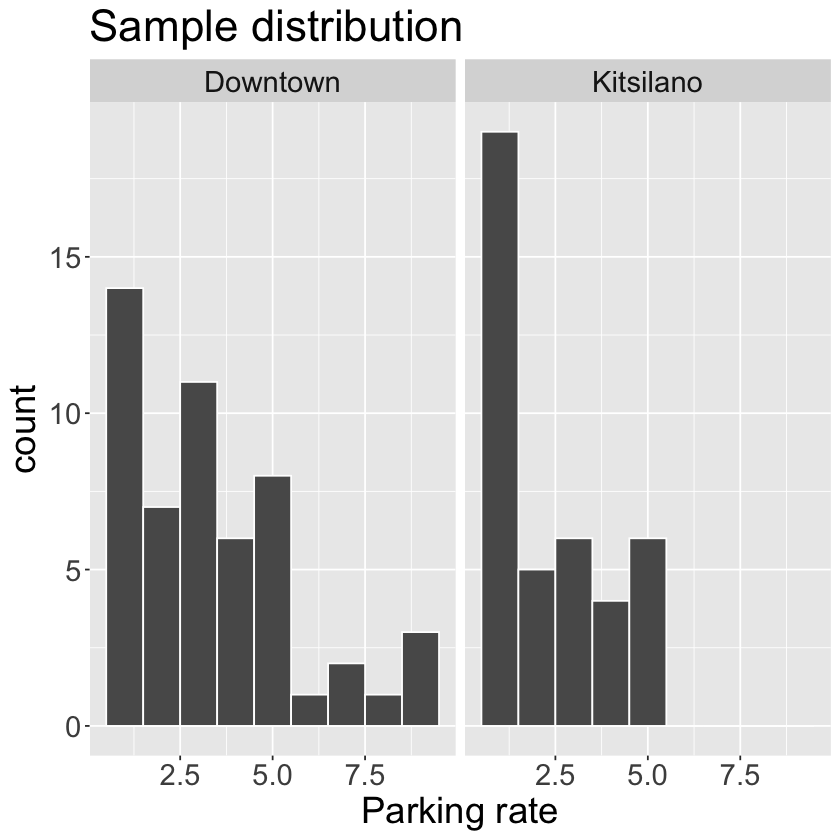

In [16]:
# parking_samp_dist_plot <- 
#     downtown_kitsilano_sample %>% 
#     ... + 
#     ...(..., ... = 1, color = 'white') +
#     facet_wrap(~ geo_local_area) + 
#     ...
#     theme(text = element_text(size = 22))


### BEGIN SOLUTION
parking_samp_dist_plot <- 
    downtown_kitsilano_sample %>% 
    ggplot() + 
    geom_histogram(aes(r_mf_9a_6p), binwidth = 1, color = 'white') +
    facet_wrap(~ geo_local_area) + 
    theme(text = element_text(size = 22)) +
    ggtitle("Sample distribution") + 
    xlab("Parking rate")
### END SOLUTION

parking_samp_dist_plot

In [17]:
test_2.1()

Test passed 🥇
Test passed 😀
Test passed 🎉
Test passed 😀
Test passed 🎉
Test passed 😀
Test passed 🥇
[1] "Success!"


**Question 2.2** 
<br> {points: 1}

Obtain the sample averages of parking rates for each region, `Kitsilano` and `Downtown`, as well as their standard error.

_Assign your data frame to an object called `parking_summary`. The data frame should have three columns: (1) `geo_local_area`; (2) `sample_mean`; and (3) `sample_std_error`_

In [18]:
### BEGIN SOLUTION
parking_summary <- 
    downtown_kitsilano_sample %>% 
    group_by(geo_local_area) %>% 
    summarise(sample_mean = mean(r_mf_9a_6p),
              sample_std_error = sd(r_mf_9a_6p)/sqrt(n()))
### END SOLUTION

head(parking_summary)

geo_local_area,sample_mean,sample_std_error
<chr>,<dbl>,<dbl>
Downtown,3.396226,0.3110678
Kitsilano,2.325000,0.2412242


In [19]:
test_2.2()

Test passed 😀
Test passed 🥇
Test passed 🥇
Test passed 😀
Test passed 😸
[1] "Success!"


**Question 2.3** 
<br> {points: 1}

Obtain a 94% confidence interval for the difference between the means of Downtown and Kitsilano's parking rates using the CLT. 

_Assign your data frame to an object called `parking_clt_ci`. The data frame should have two columns: `lower_ci` and `upper_ci`._

In [20]:
# downtown_mean <- parking_summary$...
# downtown_var <- ...
# kits_mean <- ...
# kits_var <- ...

# parking_clt_ci <- 
#     tibble(lower_ci = ...,
#            upper_ci = ...)

### BEGIN SOLUTION
downtown_mean <- parking_summary$sample_mean[1]
downtown_var <- parking_summary$sample_std_error[1]^2
kits_mean <- parking_summary$sample_mean[2]
kits_var <- parking_summary$sample_std_error[2]^2

parking_clt_ci <- 
    tibble(lower_ci = (downtown_mean - kits_mean - qnorm(0.97) * sqrt(kits_var + downtown_var)),
           upper_ci = (downtown_mean - kits_mean + qnorm(0.97) * sqrt(kits_var + downtown_var)))
### END SOLUTION

head(parking_clt_ci)

lower_ci,upper_ci
<dbl>,<dbl>
0.3308713,1.811582


In [21]:
# Here we check to see if you have given your answer the correct object name
# and if your answer is plausible. However, all other tests have been hidden
# so you can practice deciding when you have the correct answer.
test_that('Did not assign answer to an object called "parking_clt_ci"', {
  expect_true(exists("parking_clt_ci"))
})
test_that("Solution should be a data frame", {
  expect_true("data.frame" %in% class(parking_clt_ci))
})

### BEGIN HIDDEN TESTS
expected_colnames <- c("lower_ci", "upper_ci")
given_colnames <- colnames(parking_clt_ci)
test_that("Data frame does not have the correct columns", {
  expect_equal(length(setdiff(
    union(expected_colnames, given_colnames),
    intersect(expected_colnames, given_colnames)
  )), 0)
})

test_that("Data frame does not contain the correct number of rows", {
  expect_equal(digest(as.integer(nrow(parking_clt_ci))), "4b5630ee914e848e8d07221556b0a2fb")
})

test_that("Data frame does not contain the correct data", {
      expect_equal(digest(as.integer(parking_clt_ci$lower_ci+parking_clt_ci$upper_ci * 10e6)), "5aa2c08214afc7ce67726e78c9b741dc")
})

print("Success!")
### END HIDDEN TESTS

Test passed 😀
Test passed 🥇
Test passed 🎊
Test passed 🎉
Test passed 🥳
[1] "Success!"


**Question 2.4**
<br> {points: 1}


Are these intervals accurate? In other words, if we were to do this process multiple times, will we capture the true parking rate difference approximately 94% of the time?  This is what we are going to investigate in this exercise. We have already taken 100 samples saved in the `parking_multiple_ci` object. 

Your job is:
1. add two columns to the `parking_multiple_ci` data frame, namely, `lower_ci` and `upper_ci` with the lower and upper bound of the respective confidence interval. 
2. add a third column, `captured`, with `TRUE` or `FALSE`, if the interval captured the true difference. 
3. finally, select only the `replicate`, `lower_ci`, `upper_ci`, and `captured` columns.


_Assign your plot to an object called `parking_multiple_ci`._

In [22]:
# Run this cell before continuing

set.seed(20210301) # Do not change this.

# Obtain the means of parking rates in each neighbourhood.
true_means <-
    parking_pop %>% 
    group_by(geo_local_area) %>% 
    summarise(sample_mean = mean(r_mf_9a_6p)) %>% 
    pull(sample_mean)

# Obtain the true difference in mean
true_diff = true_means[1] - true_means[2]

parking_multiple_samples <- 
    tibble(replicate = 1:100) %>% 
    mutate(sample = map(replicate,
                        `.f` = ~
                            parking_pop %>% 
                            group_by(geo_local_area) %>% 
                            sample_n(size = case_when(geo_local_area == "Downtown" ~ 53,
                                                      geo_local_area == "Kitsilano" ~ 40), replace = FALSE) %>% 
                            ungroup() 
                    )
    ) %>% 
    unnest(sample) %>% 
    group_by(replicate, geo_local_area) %>% 
    summarise(sample_mean = mean(r_mf_9a_6p),
              sample_std_error = sd(r_mf_9a_6p)/sqrt(n()),
              n = n()) %>% 
    pivot_wider(names_from = geo_local_area, values_from = c(sample_mean, sample_std_error, n))

head(parking_multiple_samples)

`summarise()` has grouped output by 'replicate'. You can override using the `.groups` argument.



replicate,sample_mean_Downtown,sample_mean_Kitsilano,sample_std_error_Downtown,sample_std_error_Kitsilano,n_Downtown,n_Kitsilano
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,3.528302,2.4000,0.2791156,0.2601775,53,40
2,3.528302,2.3500,0.2883864,0.2620188,53,40
3,4.000000,2.3250,0.3047757,0.2490688,53,40
4,2.764151,2.4000,0.2742597,0.2698528,53,40
5,3.443396,2.3500,0.3129001,0.2898939,53,40
6,3.811321,1.9125,0.3365243,0.2117445,53,40


In [23]:
# parking_multiple_ci <-
#     parking_multiple_samples %>% 
#     mutate(lower_ci = ...,
#            upper_ci = ...) %>% 
#     select(replicate, lower_ci, upper_ci) %>% 
#     mutate(captured = between(true_diff, ..., ...))


### BEGIN SOLUTION

parking_multiple_ci <-
    parking_multiple_samples %>% 
    mutate(lower_ci = sample_mean_Downtown - sample_mean_Kitsilano - qnorm(0.97) * sqrt(sample_std_error_Downtown^2+sample_std_error_Kitsilano^2),
           upper_ci = sample_mean_Downtown - sample_mean_Kitsilano + qnorm(0.97) * sqrt(sample_std_error_Downtown^2+sample_std_error_Kitsilano^2)) %>% 
    select(replicate, lower_ci, upper_ci) %>% 
    mutate(captured = between(true_diff, lower_ci, upper_ci))

### END SOLUTION

head(parking_multiple_ci)

replicate,lower_ci,upper_ci,captured
<int>,<dbl>,<dbl>,<lgl>
1,0.4106422,1.845962,TRUE
2,0.4454664,1.911137,TRUE
3,0.9347136,2.415286,TRUE
4,-0.3594999,1.087802,TRUE
5,0.2911437,1.895649,TRUE
6,1.1510205,2.646621,FALSE


In [24]:
test_2.4()

Test passed 🌈
Test passed 🌈
Test passed 🎉
Test passed 🥇
Test passed 😸
[1] "Success!"


Nice job! Run the cell below to visualize the confidence intervals.

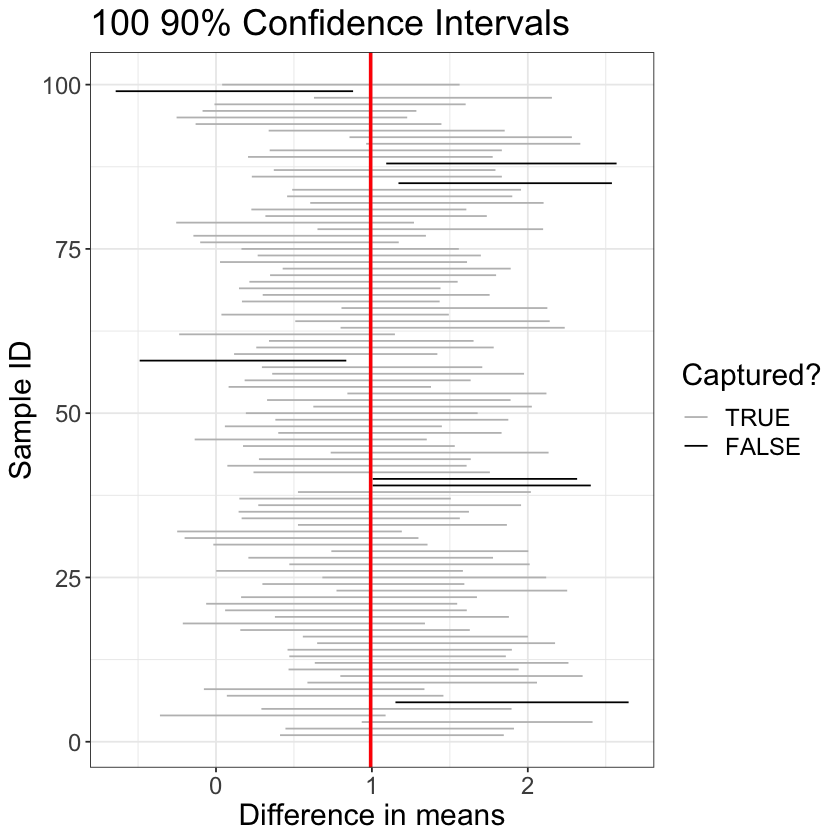

In [25]:
parking_multiple_ci %>% 
    ggplot() +
    scale_colour_manual(breaks = c("TRUE", "FALSE"), # Change colour scale for better visibility.
                        values = c("grey", "black")) +
    geom_segment(aes(x = lower_ci,
                     xend = upper_ci,
                     y = replicate,
                     yend = replicate,
                     colour = captured)) +
    geom_vline(xintercept = true_diff, colour = "red", size = 1) +
    labs(title = "100 90% Confidence Intervals",
         x = 'Difference in means',
         y = "Sample ID",
         colour = "Captured?") +
    theme_bw() + # Sets a theme for better visibility.
    theme(text = element_text(size = 18)) 
    

As you can see, the CLT approximation seems quite reasonable, even though our population is not Normal.

## 3. Estimating Proportions using CLT

There was a provincial election in British Columbia in 2020. Before the election, the pollsters were hard at work trying to estimate the proportion of votes each party would get if the election happened when the data was collected. In this section, we will work with a data set from [a poll performed by the Angus Reid Institute](https://angusreid.org/bc-election-post-debate/) that asked people which party they intended to vote for. Let's start by reading the data set.


In [26]:
polls <- 
    read_csv("angus_reid_poll.csv") %>% 
    mutate(party = as.factor(party))

head(polls)

Rows: 714 Columns: 1

── Column specification ───────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): party


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



party
<fct>
BC Liberals
BC NDP
BC Green Party
BC Liberals
BC NDP
BC NDP


**Question 3.1** 
<br> {points: 1}

Since we intend to use the CLT, let us start by calculating the quantities that we need:

1. the total number of votes each party received, this should be stored in a column named `n`;
2. the proportion of votes each party received, this should be stored in a column named `prop`;
3. the standard error of the sample proportion of each party, which should be stored in a column named `se`;
3. lower and upper boundaries of the 90% confidence interval, stored in columns `lower_ci` and `upper_ci` respectively;

_Assign your data frame to an object called `polls_summary`._

In [27]:
# polls_summary <- 
#     polls %>% 
#     ... %>% 
#     summarise(n =  n(),
#               prop = ...,              
#               se = ...,
#               lower_ci = ...,
#               upper_ci = ...) %>% 
#     mutate(party = fct_reorder(party, prop, .desc = TRUE))

### BEGIN SOLUTION
polls_summary <- 
    polls %>% 
    group_by(party) %>% 
    summarise(prop = n() / nrow(polls),
              n =  n(),
              se = sqrt(prop * (1 - prop) / nrow(polls) ),
              lower_ci = prop - (qnorm(0.975) * se),
              upper_ci = prop + (qnorm(0.975) * se)) %>% 
    mutate(party = fct_reorder(party, prop, .desc = TRUE))
### END SOLUTION

head(polls_summary)

party,prop,n,se,lower_ci,upper_ci
<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Another party,0.04761905,34,0.007969785,0.03199856,0.06323954
BC Green Party,0.13725490,98,0.012878227,0.11201404,0.16249576
BC Liberals,0.32773109,234,0.017566338,0.29330170,0.36216048
BC NDP,0.48739496,348,0.018706083,0.45073171,0.52405821


In [28]:
# Here we check to see if you have given your answer the correct object name
# and if your answer is plausible. However, all other tests have been hidden
# so you can practice deciding when you have the correct answer.
test_that('Did not assign answer to an object called "polls_summary"', {
  expect_true(exists("polls_summary"))
})
test_that("Solution should be a data frame", {
  expect_true("data.frame" %in% class(polls_summary))
})
expected_colnames <- c("party", "prop", "n", "se", "lower_ci", "upper_ci")

given_colnames <- colnames(polls_summary)
test_that("Data frame does not have the correct columns", {
  expect_equal(length(setdiff(
    union(expected_colnames, given_colnames),
    intersect(expected_colnames, given_colnames)
  )), 0)
})

test_that("Data frame does not contain the correct number of rows", {
  expect_equal(digest(as.integer(nrow(polls_summary))), "234a2a5581872457b9fe1187d1616b13")
})


### BEGIN HIDDEN TESTS
test_that("Data frame does not contain the correct data", {
    expect_equal(digest(as.integer(sum(polls_summary$prop) * 10e6)), "e70c8aebf8e11c6fa4c9d6fc367d7fc9")
    expect_equal(digest(as.integer(sum(polls_summary$n))), "1ca78180d8528ea0a2e5807559c93229")
    expect_equal(digest(as.integer(sum(polls_summary$se) * 10e6)), "c28860f1c3af2490f74916cfd0ff9d25")
    expect_equal(digest(as.integer(sum(polls_summary$lower_ci) * 10e6)), "5d2c81d7292b016071dbb7761c21fc84")
    expect_equal(digest(as.integer(sum(polls_summary$upper_ci) * 10e6)), "0992bc7d957a8f39a1759e71560fb1a4")
})

print("Success!")
### END HIDDEN TESTS

Test passed 🥇
Test passed 😀
Test passed 🥳
Test passed 🥳
Test passed 🎊
[1] "Success!"


How about we visualize the information you obtained with a plot? 

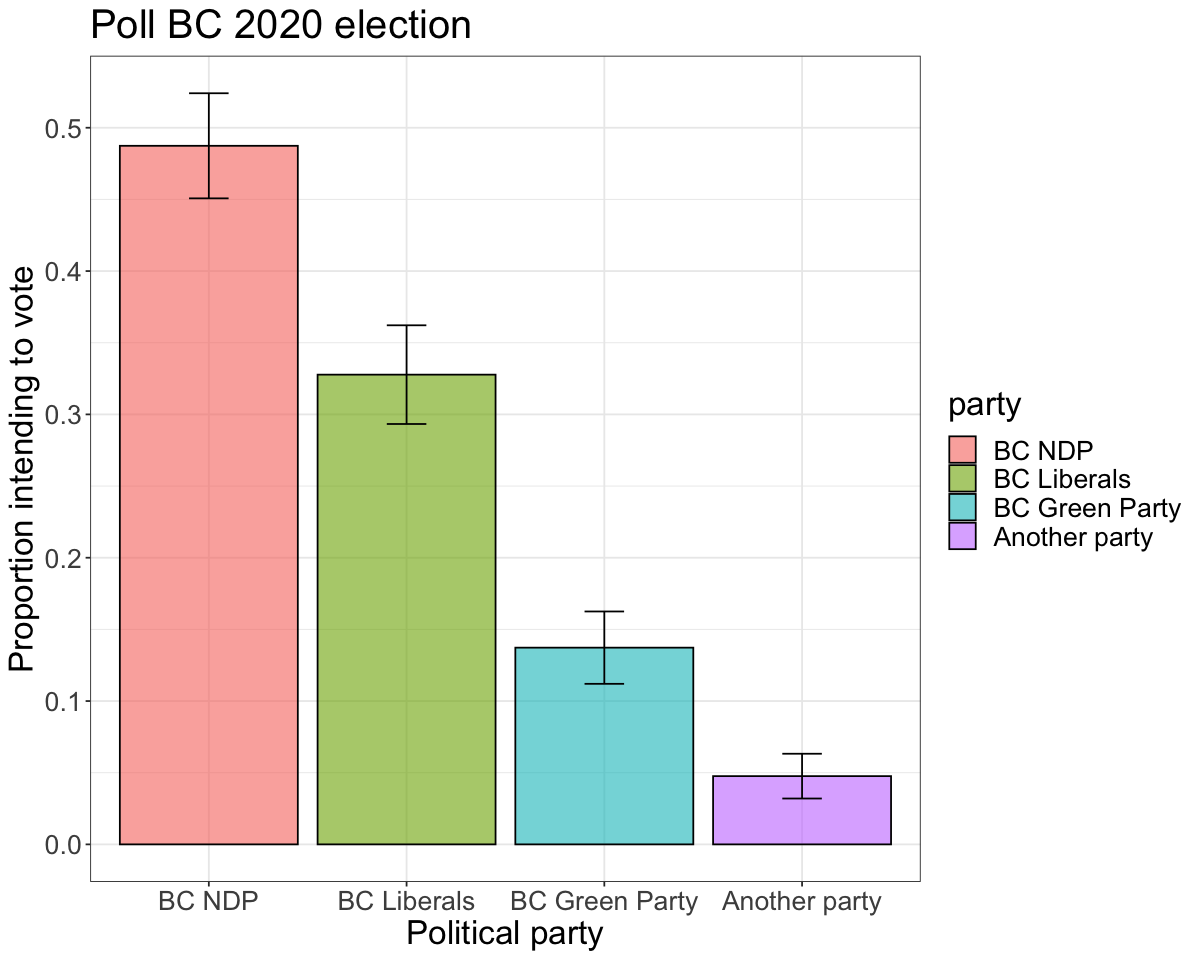

In [29]:
options(repr.plot.width = 10, repr.plot.height = 8)

poll_ci_plot <- 
    polls_summary %>% 
    ggplot(aes(x = party, y = prop, fill=party)) +
      geom_bar(stat = "identity", 
               colour="black",
               alpha = .6) +
      geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci),
                    size = 0.5, color = "black", width=.2) +
      theme_bw() +
      xlab("Political party") +
      ylab("Proportion intending to vote") +
      theme(text = element_text(size = 20)) + 
      ggtitle("Poll BC 2020 election")

poll_ci_plot

**Question 3.2** 
<br> {points: 4}

Use written English to interpret and report the estimates (and their confidence intervals) for each party. Is there any concern over using the CLT to obtain the confidence interval for the proportion for any of the parties?


### BEGIN SOLUTION
We calculated an estimate that 48.74% of people intend to vote for the BC NDP party and we are 90% “confident” that true value for this is between 45.07 and 52.41%.

We calculated an estimate that 32.77% of people intend to vote for the BC Liberals party and we are 90% “confident” that true value for this is between 29.33 and 36.22%.

We calculated an estimate that 13.73% of people intend to vote for the BC Green Party party and we are 90% “confident” that true value for this is between 11.2 and 16.25%.

We calculated an estimate that 4.76% of people intend to vote for Another party and we are 90% “confident” that true value for this is between 3.2 and 6.32%. One might say that the CLT is inappropriate in this case, as the sample proportion is quite low and $p\times n\approx 1.8$, which indicates that the CLT will be a poor aproximation of the sampling distribution in this case. 
### END SOLUTION

## 4. Estimating difference in proportions using CLT

In Question 3 of Tutorial 6, we used the [Breast Cancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer) data set and studied the effects of radiation therapy on the recurrence of breast cancer. Now, we will obtain the confidence interval of the difference in proportions by bootstrapping and CLT.

In [30]:
breast_cancer <- 
    read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data"), 
             col_names = c("class", "age", "menopause", "tumor-size", "inv-nodes", "node-caps", "deg-malig", "breast", "breast-quad", "irradiat")) %>% 
    select(class, irradiat)

# Taking a peek of the data set
breast_cancer %>% 
    group_by(class,irradiat) %>% 
    sample_n(size = 2)

Rows: 286 Columns: 10

── Column specification ───────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (9): class, age, menopause, tumor-size, inv-nodes, node-caps, breast, br...
dbl (1): deg-malig


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



class,irradiat
<chr>,<chr>
no-recurrence-events,no
no-recurrence-events,no
no-recurrence-events,yes
no-recurrence-events,yes
recurrence-events,no
recurrence-events,no
recurrence-events,yes
recurrence-events,yes


Let $p_{1}$ be the proportion of patients with past radiation treatment (irradiate=yes) that had recurrent cancer, and let $p_{2}$ be the proportion of patients with no radiation treatment (irradiate=no) that had recurrent cancer. We would like to study $p_1-p_2$ and find its 95% confidence interval.

<b>Question 4.1: Sample Proportions</b>
<br>{points: 1}

Find the sample proportions of $p_1$ (proportion of patients with radiation treatment with recurrent cancer) and $p_2$ (proportion of patients without radiation treatment with recurrent cancer).

<i>Assign your answers to a data frame named `p_summary`. The data frame should have four columns: `p_yes` and `p_no`, `n_yes`, `n_no`.</i>

In [31]:
### BEGIN SOLUTION
p_summary <- 
    breast_cancer %>% 
    group_by(class, irradiat) %>% 
    summarise(p = n()) %>% 
    group_by(irradiat) %>% 
    mutate(n = sum(p), p = p / sum(p)) %>% 
    filter(class == 'recurrence-events') %>% 
    select(-class) %>% 
    pivot_wider(names_from = irradiat, values_from = c(n,p))
### END SOLUTION

p_summary

`summarise()` has grouped output by 'class'. You can override using the `.groups` argument.



n_no,n_yes,p_no,p_yes
<int>,<int>,<dbl>,<dbl>
218,68,0.2477064,0.4558824


In [32]:
test_4.1()

Test passed 🎊
Test passed 😸
Test passed 😸
Test passed 🥳
Test passed 🌈
[1] "Success!"


<b> Question 4.2 </b>
<br>{points: 1}

Add two more columns to the `p_summary` data frame: 

1. `p_diff` to store the observed difference in proportion, i.e., $\hat{p_1}-\hat{p_2}$;
2. `p_diff_std_error` to store the sample standard error of the difference in proportions.

In [33]:
# p_summary <-
#     p_summary %>% 
#     mutate(p_diff = ...,
#            p_diff_std_error = ...)

### BEGIN SOLUTION
p_summary <-
    p_summary %>% 
    mutate(p_diff = p_yes - p_no,
           p_diff_std_error = sqrt(p_yes*(1-p_yes)/n_yes + p_no*(1-p_no)/n_no))
### END SOLUTION

p_summary

n_no,n_yes,p_no,p_yes,p_diff,p_diff_std_error
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
218,68,0.2477064,0.4558824,0.2081759,0.06710182


In [34]:
test_4.2()

Test passed 🎊
Test passed 🎉
Test passed 🌈
Test passed 🥇
Test passed 🎉
[1] "Success!"


<b>Question 4.3</b>
<br>{points: 1}

Finally, obtain the 95% confidence interval for the difference in proportion. Add two more columns to `p_summary` data frame: (1) `lower_ci`; and (2) `upper_ci`.

In [35]:
# p_summary <- 
#     p_summary %>% 
#     mutate(lower_ci = qnorm(..., ..., ...),
#            upper_ci = ...)

### BEGIN SOLUTION
p_summary <- 
    p_summary %>% 
    mutate(lower_ci = qnorm(0.025, p_diff, p_diff_std_error),
    upper_ci = qnorm(0.975, p_diff, p_diff_std_error)
)
### END SOLUTION

p_summary

n_no,n_yes,p_no,p_yes,p_diff,p_diff_std_error,lower_ci,upper_ci
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
218,68,0.2477064,0.4558824,0.2081759,0.06710182,0.07665877,0.3396931


In [36]:
# Here we check to see if you have given your answer the correct object name
# and if your answer is plausible. However, all other tests have been hidden
# so you can practice deciding when you have the correct answer.

test_that('Did not assign answer to an object called "p_summary"', {
expect_true(exists("p_summary"))
})

test_that("Solution should be a data frame", {
expect_true("data.frame" %in% class(p_summary))
})

expected_colnames <- c("n_no", "n_yes", "p_no", "p_yes", "p_diff", "p_diff_std_error", "lower_ci", "upper_ci")
given_colnames <- colnames(p_summary)
test_that("Data frame does not have the correct columns", {
expect_equal(length(setdiff(
  union(expected_colnames, given_colnames),
  intersect(expected_colnames, given_colnames)
)), 0)
})

test_that("Data frame does not contain the correct number of rows", {
expect_equal(digest(as.integer(nrow(p_summary))), "4b5630ee914e848e8d07221556b0a2fb")
})
### BEGIN HIDDEN TESTS
  test_that("Data frame does not contain the correct data", {
    expect_equal(digest(as.integer(sum(p_summary$n_no))), "69291c7a64149c882605dffd1b74141a")
    expect_equal(digest(as.integer(sum(p_summary$n_yes))), "1b387a44b518030b040d524a5fa7e672")
    expect_equal(digest(as.integer(sum(p_summary$p_no) * 10e6)), "36501df683b8973ff0c3976c5eea9f1c")
    expect_equal(digest(as.integer(sum(p_summary$p_yes) * 10e6)), "759e71d4a4767b90c14e3c8d110b7b2a")      
    expect_equal(digest(as.integer(sum(p_summary$p_diff) * 10e6)), "87ed83a98443f988e25cb2f2d75bfc4b")
    expect_equal(digest(as.integer(sum(p_summary$p_diff_std_error) * 10e6)), "5e18c6c71d9faf021165f2e491b4c019")
    expect_equal(digest(as.integer(sum(p_summary$lower_ci) * 10e6)), "14af2d6030374ac1af966a863ffd4765")
    expect_equal(digest(as.integer(sum(p_summary$upper_ci) * 10e6)), "9adc7038d23c41a1b81763dbbbba7b94")
  })

  print("Success!")
### END HIDDEN TESTS

Test passed 🥳
Test passed 🎉
Test passed 🌈
Test passed 🎊
Test passed 🌈
[1] "Success!"


<b>Question 4.4: Confidence Interval by Bootstrap</b>
<br>{points: 1}

Obtain the 95% confidence interval of the difference of proportions ($p_1-p_2$) via bootstrapping by generating 1000 samples from `breast_cancer`.
```r
diff_in_props_btsp_ci <- 
    breast_cancer %>%
    specify(formula = class ~ irradiat, success=...) %>%
    generate(...) %>%
    calculate(stat = ..., order = c(...)) %>%
    get_ci()
```
<i>Assign your answer to a variable called ` diff_in_props_btsp_ci`</i>.

In [37]:
set.seed(20210301) # Do not change this

### BEGIN SOLUTION
diff_in_props_btsp_ci <- 
    breast_cancer %>%
    specify(formula = class ~ irradiat, success="recurrence-events") %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in props", order = c("yes", "no")) %>%
    get_ci()
### END SOLUTION

diff_in_props_btsp_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.07527387,0.3493027


In [38]:
test_4.4()

Test passed 🥇
Test passed 😀
Test passed 🌈
Test passed 🎉
Test passed 🎊
[1] "Success!"
